# Loading and Preprocessing

### Importing libraries

In [ ]:
import time
import os
import random
import math
import pickle

import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch import tensor
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import KFold
from tqdm.auto import tqdm


%matplotlib inline

### Mounting Data to google Drive and changing the 

In [ ]:
 assert os.environ['COLAB_GPU'], 'Make sure to select GPU from Edit > Notebook settings > Hardware accelerator'
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 !rm -f data
 !ln -s '/content/drive/My Drive/proj1_data' data


### Reader Class Provided

In [ ]:
class MyDataset(Dataset):
    def __init__(self, folders, transform=None):
        self.folders, self.labels = self.get_labels(folders)
        self.transform = transform

    def __len__(self):
        return len(self.folders)
    
    def __getitem__(self, idx):
        folder_id = self.folders[idx]
        
        try:
            with open(folder_id, 'rb') as f:
                color_img = pickle.load(f)
        except EOFError:
            print(folder_id)

        # img process
        for i in range(color_img.shape[0]):
            if np.ptp(color_img[i, :, :]) != 0:
                color_img[i,:,:] = (color_img[i,:,:] - np.min(color_img[i,:,:])) / np.ptp(color_img[i,:,:])
        color_img = color_img.transpose((1,2,0))
        color_img = np.resize(color_img,(224,224,4))

        # img process
        c1 = color_img[:,:,0]
        c2 = color_img[:,:,1]
        c3 = color_img[:,:,2]
        c4 = color_img[:,:,3]
        
        c1 = np.expand_dims(c1, axis=2)
        c2 = np.expand_dims(c2, axis=2)
        c3 = np.expand_dims(c3, axis=2)
        c4 = np.expand_dims(c4, axis=2)

        color_img = np.concatenate((c1, c2, c3, c4), axis=2)
        for i in range(color_img.shape[2]):
            if np.ptp(color_img[:,:,i]) == 0:
                continue
            color_img[:,:,i] = (color_img[:,:,i] - np.min(color_img[:,:,i])) / np.ptp(color_img[:,:,i])

        # img process, tranform
        if color_img[1][1][1]>1 or color_img[1][1][1]<0:
             return color_img, self.labels[idx]
        elif self.transform is not None:
            color_img = np.uint8(255*color_img)
            color_img = Image.fromarray(color_img)
            color_img = self.transform(color_img)
            color_img = color_img.permute(1,2,0)
        return color_img, self.labels[idx]


    def get_labels(self, folders):

        files = []
        labels = []

        #conding=utf8  
        g = os.walk(folders)  

        for path, _, file_list in g:  
            for file_name in file_list:
                files.append(os.path.join(path, file_name))
                if 'nil_HS_H08' in file_name or 'light_HS_H08' in file_name:
                    labels.append(0)
                elif 'moderate_HS_H08' in file_name:
                    labels.append(1)
                else:
                    labels.append(2)
        return files, labels

    def remove_indexes(self, idxs):
      self.folders = [i for j, i in enumerate(self.folders) if j not in idxs]


#[self.folders[i] for i in range(len(self.folders))]

### Load And Preprocess the Data
After loading the data and checking the size, we noticed that much of the data had pixel values bigger than 1 and smaller than 0, which was dirty data. This interfered when we trained the model, hence we cleaned the data, by removing such occurrences in the dataset. We cleaned the train and validate datasets.


In [ ]:
past=time.time()
#train data
train = MyDataset('data/train')
#check size
a, b = train[1]
print(a.shape)
#validate data
validate= MyDataset('data/validate')

def clean(daset):
  blank=[]
  for i in range(len(daset)):
    a, b=daset[i]
    if i%100==0:
      print('%2d %%'%(100*i/len(daset)) , end='  ')
    if a[1][1][1]>1 or a[1][1][1]<0: #this works since all have same values
      blank.append(i)
  print(len(daset))
  daset.remove_indexes(blank)
  print(len(daset))

clean(train)
clean(validate)
print('Cleaning and first run through data in:  '+str(time.time()-past)+' seconds')

(224, 224, 4)
 0 %   5 %  11 %  17 %  22 %  28 %  34 %  39 %  45 %  51 %  57 %  62 %  68 %  74 %  79 %  85 %  91 %  96 %  1754
1619
 0 %  32 %  65 %  98 %  306
273
Cleaning and first run through data in:  549.0578336715698 seconds


### Cout the occurences  of each label in training set
Here we calculate the number of times each label occurred in the train and validate dataset.

In [ ]:
trainSIZES = torch.zeros(3)
for Xim, label in train:
  trainSIZES[label]+=1
print(trainSIZES)

valSIZES = torch.zeros(3)
for Xim, label in validate:
  valSIZES[label]+=1
print(valSIZES)

tensor([591., 704., 324.])
tensor([187.,  81.,   5.])


### Helper function to reset the Model

In [ ]:
def reset_model(model):
    model = baseline1()
    model = model.cuda()

#TASK 1

- Model specification: For our baseline model we have 4 convolutional layers and 3 Fully connected layers, we input an image tensor with dimensions (224x224x4) and then is passed through the convolutional layers. Every convolution and fc layers is followed by normalization do that we obtain a standarize inputs for the next layers. We also implement the dropout function after the first, second convolution, and the second fully connected layer in order to supress overfitting. The input for the first FC is 112x112x32 which is then reduced to 128 and then is linearly flattened give one of the 3 outputs. 
We also have a function to assign weights, that are normally distributed to the model. Dropout was also added

- Tuning procedure of hyperparameters: We tried to changed the number of layers, and found that more convolutional layers had a lower accuracy, so we stuck to 3 convolutional layers.

- Hyperparameters: We used a stride of 1 step and a padding of 1 pixels for all the layers

- Training and validation set performance results (precision, recall, F1) on NIL/MOD/SEV: The model is trained using the training function. The F1 value is calculated in the testing function

###Model Implementation

In [ ]:
class baseline1(nn.Module):
  def __init__(self):
    super(baseline1, self).__init__()
    self.conv1 = nn.Conv2d(4, 8, 3, 1, 1)
    self.bnm1 = nn.BatchNorm2d(num_features=8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
    self.bnm2 = nn.BatchNorm2d(num_features=16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
    self.bnm3 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.conv4 = nn.Conv2d(32, 64, 3, 1, 1)
    self.bnm4 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.fc1 = nn.Linear(802816, 128)
    self.bnm5 = nn.BatchNorm1d(128, momentum=0.1)
    self.fc2 = nn.Linear(128, 64)
    self.bnm6 = nn.BatchNorm1d(64, momentum=0.1)
    self.fc3 = nn.Linear(64, 3)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bnm1(x)
    x = F.relu(x)
    x = F.dropout2d(x, 0.2)
    x = self.conv2(x)
    x = self.bnm2(x)
    x = F.relu(x)
    x = F.dropout2d(x, 0.1)
    x = self.conv3(x)
    x = self.bnm3(x)
    x = F.relu(x)
    x = self.conv4(x)
    x = self.bnm4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.bnm5(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = self.bnm6(x)
    x = F.relu(x)
    x = F.dropout(x,0.4)
    x = self.fc3(x)
    return x


model = baseline1()

print(model)

baseline1(
  (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=802816, out_features=128, bias=True)
  (bnm5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bnm6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in

### F1 Function
In this section, we define a function that computes the number of true positives (TP), true negatives (TN), false positives (FP) and false negatives (FN). The f1 function computes the f1 values.

In [ ]:
def perf_measure(y_actual, y_hat, lbl):
  TP = 0
  FP = 0
  TN = 0
  FN = 0

  for i in range(len(y_hat)): 
    if y_actual[i]==y_hat[i]==lbl:
      TP += 1
    if y_hat[i]==lbl and y_actual[i]!=lbl:
      FP += 1
    if y_actual[i]==y_hat[i]!=lbl:
      TN += 1
    if y_hat[i]!=lbl and y_actual[i]==lbl:
      FN += 1

  return(TP, FP, TN, FN)

def F1(TP, FP, TN, FN):
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*(precision*recall)/(precision+recall)
    return f1

Here, we define the criterion to be cross entropy loss and we use SGD for the optimizer with a learning rate of 0.001 and momentum of 0.9.

In [ ]:
model = baseline1()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

model = model.cuda()
criterion = criterion.cuda()

baseline1(
  (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=802816, out_features=128, bias=True)
  (bnm5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bnm6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in

Helper function to plot losses after training.

In [ ]:
def plot_losses(losses):
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    _ = plt.ylim()

### Set DATA loaders for validation and training


In [ ]:
gpu_available = torch.cuda.is_available()
batch_size = 32
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(validate, batch_size=batch_size, pin_memory=True)
classes = ['NIL','MOD','SEV']
loaders = {
    'train': train_loader,
    'valid': valid_loader,
    'test': valid_loader
}$

Here we are defining a training function, which takes the following parameters, a loader, modeel, optimizers, a function that checks whether gpu is available, and a boolean variable. In this function we train the model. The next function is a validate function, which evaluates the model and updates the validation loss. The final function is a function that runs through the desired number of epochs, evaluates the best model based on the minimum validation loss. It saves the best model in 'model.pt'

In [ ]:
#train function, running for 20 epochs for now
def training(loader, model, optimi, criterion, gpu_available, sumloss=False, DRW=False, decay=False):     
    train_loss = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        inputs = Variable(data.cuda())
        inputs = inputs.permute(0, 3, 1, 2)
        targets = Variable(target.cuda())
        if DRW:
            mult=torch.div(1.0, trainSIZES)[targets].sum()
            print(mult,end=' ')
            if decay:
                optimi= optim.SGD(model.parameters(), lr=0.0001*mult, momentum=0.9, weight_decay=decay)
            else:
                optimi= optim.SGD(model.parameters(), lr=0.0001*mult, momentum=0.9)
        if gpu_available:
            data, target = data.cuda(), target.cuda()
        optimi.zero_grad()
        output = model(inputs)
        loss = criterion(output, target)
        loss.backward()
        optimi.step()
        if sumloss:
            train_loss+=loss.data
        else:
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
          
    return model, train_loss
        

def validation(loader, model, optim, criterion, gpu_available, sumloss=False): 
    valid_loss = 0.0
    model.eval()
    for batch_idx, (data, target) in enumerate(loader):
            
        if gpu_available:
            data, target = data.cuda(), target.cuda()
        inputs = data.permute(0, 3, 1, 2)
        output = model(inputs)
        loss = criterion(output, target)
        if sumloss:
            valid_loss+=loss.data
        else:
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss)) 
    return valid_loss


def runEpochs(num_epochs, loaders, model, optim, gpu_available ,savepath,  lossfunc='', sumloss=False ,DRW=False, decay=False, augment=False):
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.cuda()
    if lossfunc=='LDAM':
        print('Using LDAM Loss')
    else:
        print('Using cross entropy loss')
    losses = {'train':[], 'validation':[]}
    valid_loss_min = np.Inf
    if augment==True:
        loader1=loaders[1]
        loaders=loaders[0]
    for epoch in range(1, num_epochs+1):
        #training
        if lossfunc=='LDAM':
            criterion=LDAMclass(trainSIZES, DRW)
        model, train_loss = training(loaders['train'], model, optim, criterion, gpu_available, sumloss ,DRW, decay)
        losses['train'].append(train_loss) 

        if augment==True:
            if lossfunc=='LDAM':
                criterion=LDAMclass(trainSIZES, DRW)
            model, train_loss = training(loader1['train'], model, optim, criterion, gpu_available, sumloss ,DRW, decay)
            losses['train'][-1]+=(train_loss) 

            if lossfunc=='LDAM':
                criterion=LDAMclass(valSIZES)
            #print(len(loaders['valid']))
            valid_loss = validation(loader1['valid'], model, optim, criterion, gpu_available, sumloss)
            losses['validation'].append(valid_loss)
        else:
            if lossfunc=='LDAM':
                criterion=LDAMclass(valSIZES,)
            valid_loss = validation(loaders['valid'], model, optim, criterion, gpu_available, sumloss)
            losses['validation'].append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                  epoch, train_loss,valid_loss))  
            
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min, valid_loss))

            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
    model.load_state_dict(torch.load('model.pt'))
    return model, losses

In [ ]:
#change between LDAM & cross entropy
#runEpochs(num_epochs, loaders, model, optim, gpu_available ,savepath,  lossfunc='', DRW=False,decay=False):

past= time.time()
model, losses = runEpochs(20, loaders, model, optimizer, 
                       gpu_available, 'model.pt', '')
print('Time taken: '+str(time.time()-past))
#saves the model
save_name = 'task1-pure.tar'
torch.save(model, save_name)
print(f'The best model saved to {save_name}')

Using cross entropy loss
Epoch: 1 	Training Loss: 1.064518 	Validation Loss: 1.036321
Validation loss decreased (inf --> 1.036321).  Saving model ...
Epoch: 2 	Training Loss: 0.882871 	Validation Loss: 0.935675
Validation loss decreased (1.036321 --> 0.935675).  Saving model ...
Epoch: 3 	Training Loss: 0.743092 	Validation Loss: 0.902031
Validation loss decreased (0.935675 --> 0.902031).  Saving model ...
Epoch: 4 	Training Loss: 0.604054 	Validation Loss: 0.981331
Epoch: 5 	Training Loss: 0.493480 	Validation Loss: 0.875678
Validation loss decreased (0.902031 --> 0.875678).  Saving model ...
Epoch: 6 	Training Loss: 0.403690 	Validation Loss: 0.926637
Epoch: 7 	Training Loss: 0.329640 	Validation Loss: 1.029639
Epoch: 8 	Training Loss: 0.280440 	Validation Loss: 0.938383
Epoch: 9 	Training Loss: 0.235466 	Validation Loss: 0.924313
Epoch: 10 	Training Loss: 0.204827 	Validation Loss: 0.905859
Epoch: 11 	Training Loss: 0.181264 	Validation Loss: 0.966026
Epoch: 12 	Training Loss: 0.161

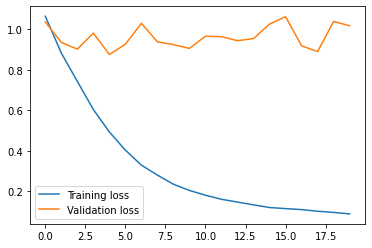

In [ ]:
plot_losses(losses)

`testing` function prints the accuracy of validation by f1-value per class and also by class percentage.

In [ ]:
def testing(loaders, model, criterion, gpu_available):
    test_loss = 0.
    correct = 0.
    total = 0.
    class_correct = list(0. for i in range(3))
    class_total = list(0. for i in range(3))
    y_hat = []
    y_actual = []

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        
        if gpu_available:
            data, target = data.cuda(), target.cuda()
        inputs = data.permute(0, 3, 1, 2)
        output = model(inputs)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
        _, pred1 = torch.max(output, 1)
        correct_tensor = pred1.eq(target.data.view_as(pred1))

        
        for i in range(len(pred1)):
          y_hat.append(classes[pred1[i]])

        correct1 = np.squeeze(correct_tensor.numpy()) if not gpu_available else np.squeeze(correct_tensor.cpu().numpy())
        
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct1[i].item()
            class_total[label] += 1
            y_actual.append(classes[label])
    for x in classes:    
      TP, FP, TN, FN = perf_measure(y_actual, y_hat, x)
      f1 = F1(TP, FP, TN, FN)
      print('f1 for class',end=' ')
      print(x, f1)  

    for i in range(3):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    print('\nTest Loss: {:.6f}\n'.format(test_loss))
    
    print('\nOverall Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [ ]:
 testing(loaders, model, criterion, gpu_available)

f1 for class NIL 0.6999999999999998
f1 for class MOD 0.588235294117647
f1 for class SEV 0.10256410256410256
Accuracy of   NIL : 59 %
Accuracy of   MOD : 67 %
Accuracy of   SEV : 40 %

Test Loss: 0.875678


Overall Test Accuracy: 61% (169/273)


###l2 Regularization
We added a weight decay parameter to the optimizer, to add l2 regularization to the training of the net

In [ ]:
reset_model(model)
optimizerl2 = optim.SGD(model.parameters(), lr=0.0001 , momentum=0.9, weight_decay=0.01)

In [ ]:
past= time.time()
#runEpochs(num_epochs, loaders, model, optim, gpu_available ,savepath,  lossfunc='', DRW=False,decay=False):
model, losses = runEpochs(20, loaders, model, optimizerl2, 
                       gpu_available, 'model.pt', '')
print('Time taken: '+str(time.time()-past))
#saves the model
save_name = 'task1-l2.tar'
torch.save(model, save_name)
print(f'The best model saved to {save_name}')


Using cross entropy loss
Epoch: 1 	Training Loss: 0.409294 	Validation Loss: 1.004971
Validation loss decreased (inf --> 1.004971).  Saving model ...
Epoch: 2 	Training Loss: 0.341558 	Validation Loss: 0.961748
Validation loss decreased (1.004971 --> 0.961748).  Saving model ...
Epoch: 3 	Training Loss: 0.291393 	Validation Loss: 0.986457
Epoch: 4 	Training Loss: 0.248256 	Validation Loss: 1.015003
Epoch: 5 	Training Loss: 0.222954 	Validation Loss: 0.962402
Epoch: 6 	Training Loss: 0.188589 	Validation Loss: 0.878623
Validation loss decreased (0.961748 --> 0.878623).  Saving model ...
Epoch: 7 	Training Loss: 0.166131 	Validation Loss: 1.061588
Epoch: 8 	Training Loss: 0.152013 	Validation Loss: 0.918099
Epoch: 9 	Training Loss: 0.135917 	Validation Loss: 0.999154
Epoch: 10 	Training Loss: 0.133537 	Validation Loss: 1.206189
Epoch: 11 	Training Loss: 0.121008 	Validation Loss: 0.941078
Epoch: 12 	Training Loss: 0.111693 	Validation Loss: 0.996363
Epoch: 13 	Training Loss: 0.105359 	Va

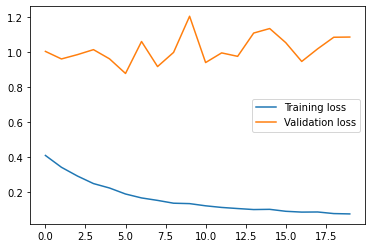

In [ ]:
plot_losses(losses)

In [ ]:
 testing(loaders, model, criterion, gpu_available)

f1 for class NIL 0.7116564417177915
f1 for class MOD 0.5760869565217391
f1 for class SEV 0.1111111111111111
Accuracy of   NIL : 62 %
Accuracy of   MOD : 65 %
Accuracy of   SEV : 40 %

Test Loss: 0.878623


Overall Test Accuracy: 62% (171/273)


## Applying transformations
To augment the data, we use multiple transforms, such as crop, horizontal flip and vertical flip that occur to random data. Then we resize the image to a 224 by 224 image and transform it from image to tensor. We clean the data after transforming to make sure that no dirty images are put through the net. After that, we add the augmented data to the original dataset.

###Transform Image


In [ ]:
transformations = transforms.Compose([
    #transforms.RandomRotation(90, resample=False, expand=False, center=None, fill=None),
    transforms.RandomCrop(150, padding=None, pad_if_needed=True, fill=0),
    #transforms.ColorJitter(brightness=0.1, contrast=0.01, saturation=0.1, hue = 0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize(224, interpolation=2),
    transforms.ToTensor()
])

 0 %   5 %  11 %  17 %  22 %  28 %  34 %  39 %  45 %  51 %  57 %  62 %  68 %  74 %  79 %  85 %  91 %  96 %  1754
1619
 0 %  32 %  65 %  98 %  306
273


<Figure size 576x576 with 0 Axes>

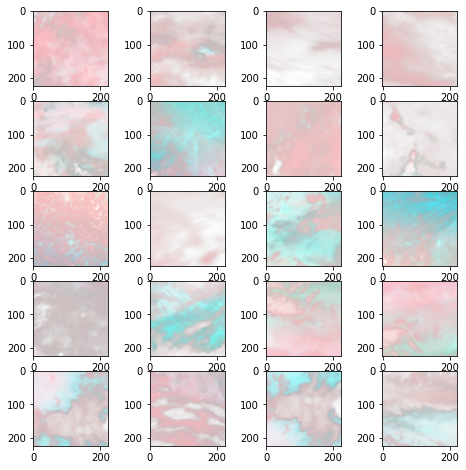

In [ ]:
train_trans = MyDataset('data/train', transform = transformations)
a, b = train_trans[14]
validate_trans = MyDataset('data/validate')
clean(train_trans)
clean(validate_trans)


fig=plt.figure(figsize=(8, 8))
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4

rows = 5
for i in range(1, columns*rows +1):
    a, b = train_trans[i]
    img = a
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### Compare to original

<Figure size 576x576 with 0 Axes>

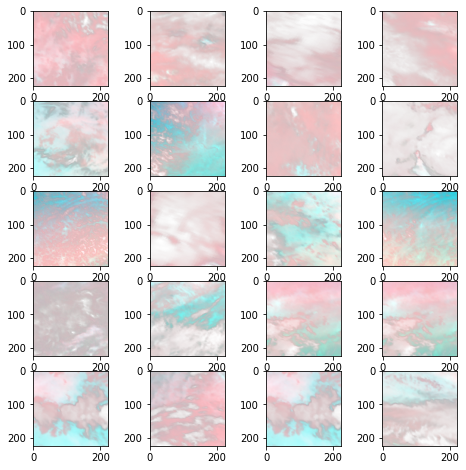

In [ ]:
fig=plt.figure(figsize=(8, 8))
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    a, b = train[i]
    img = a
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## Concatenate the two datasets

In [ ]:
a,b=train_trans[1]
print(type(a))

<class 'torch.Tensor'>


In [ ]:
#train_aug=torch.utils.data.ConcatDataset(torch.Tensor([train, train_trans]))
#validate_aug=torch.utils.data.ConcatDataset(torch.Tensor([validate, validate_trans]))

#print('Augmented Train Size: '+str(len(train_aug)))
#print('Augmented Validation Size: '+str(len(train_aug)))

trans_train_loader = torch.utils.data.DataLoader(train_trans, batch_size=batch_size, shuffle=True, pin_memory=True)
trans_valid_loader = torch.utils.data.DataLoader(validate_trans, batch_size=batch_size, pin_memory=True)

#aug_train_loader=torch.utils.data.ConcatDataset([train_loader, trans_train_loader])
#aug_validate_loader=torch.utils.data.ConcatDataset([train_loader, trans_train_loader])

#a,b=train_aug[1]

print(train)
print(type(a))

<class 'torch.Tensor'>


###Train using transformed image

In [ ]:
gpu_available = torch.cuda.is_available()
batch_size = 32
classes = ['NIL','MOD','SEV']
trans_loader = {
    'train': trans_train_loader,
    'valid': valid_loader,
    'test': valid_loader
}

In [ ]:
reset_model(model)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
past= time.time()
model, losses = runEpochs(12, [loaders, trans_loader], model, optimizer, gpu_available, 'model.pt', '', augment=True)

print('Time taken: '+str(time.time()-past))
#saves the model
save_name = 'task1-augmented.tar'
torch.save(model, save_name)
print(f'The best model saved to {save_name}')

Using cross entropy loss
Epoch: 1 	Training Loss: 1.101493 	Validation Loss: 1.099808
Validation loss decreased (inf --> 1.099808).  Saving model ...
Epoch: 2 	Training Loss: 1.082305 	Validation Loss: 1.107252
Epoch: 3 	Training Loss: 1.097381 	Validation Loss: 1.018849
Validation loss decreased (1.099808 --> 1.018849).  Saving model ...
Epoch: 4 	Training Loss: 1.076712 	Validation Loss: 1.041563
Epoch: 5 	Training Loss: 1.061824 	Validation Loss: 0.951503
Validation loss decreased (1.018849 --> 0.951503).  Saving model ...
Epoch: 6 	Training Loss: 1.093814 	Validation Loss: 1.026865
Epoch: 7 	Training Loss: 1.075221 	Validation Loss: 0.914039
Validation loss decreased (0.951503 --> 0.914039).  Saving model ...
Epoch: 8 	Training Loss: 1.082999 	Validation Loss: 1.009649
Epoch: 9 	Training Loss: 1.060821 	Validation Loss: 1.044558
Epoch: 10 	Training Loss: 1.068015 	Validation Loss: 0.956064
Epoch: 11 	Training Loss: 1.083797 	Validation Loss: 0.975152
Epoch: 12 	Training Loss: 1.099

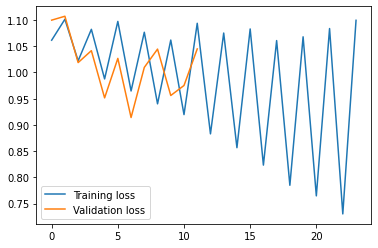

In [ ]:
plot_losses(losses)

Graph looks wonky due to an error but model weights are accurate

In [ ]:
testing(loaders, model, criterion, gpu_available)

f1 for class NIL 0.6441717791411044
f1 for class MOD 0.47
f1 for class SEV 0.1
Accuracy of   NIL : 56 %
Accuracy of   MOD : 58 %
Accuracy of   SEV : 20 %

Test Loss: 0.931770


Overall Test Accuracy: 56% (153/273)


# TASK 2

*   Tuning procedure of hyperparameters:
*   Hyperparameters:
*   Training and validation set performance results (precision, recall, F1) on NIL/MOD/SEV:

### LDAM Implementation
This is the implementation of our LDAM function. It was originally a function but required specific parameters of the sizes so a class was used instead to compute it.

In [ ]:
class LDAMclass(nn.Module):
    def __init__(self, sizes, DRW=False):
        super(LDAMclass, self).__init__()
        self.sizes = sizes.cuda()
        self.DRW=DRW

    def forward(self, outputs, targets):
          deltas=torch.div(CCC, torch.sqrt(torch.sqrt(self.sizes)) )
          deltas=deltas.cuda()
          b= torch.exp(outputs).sum(1) -torch.exp(outputs[range(outputs.shape[0]),targets])
          a=torch.exp(outputs[range(outputs.shape[0]),targets]-deltas[targets])
          res=-torch.log(a/(a + b) )
          if self.DRW:
              res=torch.dot(res,torch.div(1.0, self.sizes[targets]))
          return res.sum()/outputs.shape[0]

### Train Model choose best hyperparameter C

In [ ]:
#Training with LDAM, applying the deferred rebalancing scheme as explained in [1]
#this is the second loop with standard reweighting

#getting he right CCC value
tries=[0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
for j in tries:
    CCC=j
    reset_model(model)
    print(' ')
    print('C value is: '+str(CCC))
    #firstLDAM traning
    losses = {'train':[], 'validation':[]}
    model, losses = runEpochs(20, loaders, model, optimizer, 
                        gpu_available, 'model.pt', '', DRW=False)
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    _ = plt.ylim()
    model.load_state_dict(torch.load('model.pt'))

    testing(loaders, model, criterion, gpu_available)


## Train using LDAM with right hyperparameter $C$

In [ ]:
reset_model(model)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

CCC=0.00001
print('C value is: '+str(CCC))

C value is: 1e-05


In [ ]:
#firstLDAM traning
losses = {'train':[], 'validation':[]}
model, losses = runEpochs(20, loaders, model, optimizer, 
                  gpu_available, 'model.pt', 'LDAM', DRW=False)
model.load_state_dict(torch.load('model.pt'))
#saves the model
save_name = 'task2-pure.tar'
torch.save(model, save_name)
print(f'The best model saved to {save_name}')

Using LDAM Loss
Epoch: 1 	Training Loss: 0.082117 	Validation Loss: 1.019855
Validation loss decreased (inf --> 1.019855).  Saving model ...
Epoch: 2 	Training Loss: 0.083236 	Validation Loss: 1.045353
Epoch: 3 	Training Loss: 0.085066 	Validation Loss: 1.024432
Epoch: 4 	Training Loss: 0.078675 	Validation Loss: 0.996632
Validation loss decreased (1.019855 --> 0.996632).  Saving model ...
Epoch: 5 	Training Loss: 0.072241 	Validation Loss: 1.030100
Epoch: 6 	Training Loss: 0.066767 	Validation Loss: 1.135560
Epoch: 7 	Training Loss: 0.063515 	Validation Loss: 1.056113
Epoch: 8 	Training Loss: 0.063020 	Validation Loss: 1.026626
Epoch: 9 	Training Loss: 0.062767 	Validation Loss: 1.020687
Epoch: 10 	Training Loss: 0.058545 	Validation Loss: 1.055736
Epoch: 11 	Training Loss: 0.053279 	Validation Loss: 1.006973
Epoch: 12 	Training Loss: 0.056368 	Validation Loss: 1.099277
Epoch: 13 	Training Loss: 0.052852 	Validation Loss: 1.115478
Epoch: 14 	Training Loss: 0.052184 	Validation Loss: 1

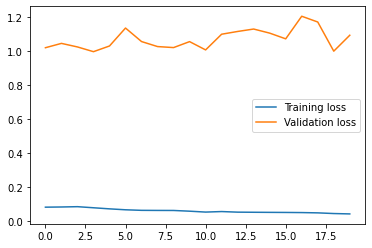

In [ ]:
plot_losses(losses)

In [ ]:
testing(loaders, model, criterion, gpu_available)

f1 for class NIL 0.6855345911949685
f1 for class MOD 0.5608465608465609
f1 for class SEV 0.10256410256410256
Accuracy of   NIL : 58 %
Accuracy of   MOD : 65 %
Accuracy of   SEV : 40 %

Test Loss: 0.996631


Overall Test Accuracy: 60% (164/273)


In [ ]:
reset_model(model)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

CCC=0.000005
print('C value is: '+str(CCC))

C value is: 5e-06


In [ ]:
#firstLDAM traning
losses = {'train':[], 'validation':[]}
model, losses = runEpochs(20, loaders, model, optimizer, 
                  gpu_available, 'model.pt', 'LDAM', DRW=False)
model.load_state_dict(torch.load('model.pt'))
#saves the model
save_name = 'task2-pure.tar'
torch.save(model, save_name)
print(f'The best model saved to {save_name}')

Using LDAM Loss
Epoch: 1 	Training Loss: 0.074340 	Validation Loss: 1.021487
Validation loss decreased (inf --> 1.021487).  Saving model ...
Epoch: 2 	Training Loss: 0.071243 	Validation Loss: 1.035684
Epoch: 3 	Training Loss: 0.070552 	Validation Loss: 1.143114
Epoch: 4 	Training Loss: 0.062773 	Validation Loss: 1.040087
Epoch: 5 	Training Loss: 0.061417 	Validation Loss: 1.073811
Epoch: 6 	Training Loss: 0.059862 	Validation Loss: 1.140041
Epoch: 7 	Training Loss: 0.061884 	Validation Loss: 1.126926
Epoch: 8 	Training Loss: 0.057145 	Validation Loss: 1.215914
Epoch: 9 	Training Loss: 0.053872 	Validation Loss: 1.116851
Epoch: 10 	Training Loss: 0.051335 	Validation Loss: 1.121846
Epoch: 11 	Training Loss: 0.050565 	Validation Loss: 0.975808
Validation loss decreased (1.021487 --> 0.975808).  Saving model ...
Epoch: 12 	Training Loss: 0.050191 	Validation Loss: 1.078164
Epoch: 13 	Training Loss: 0.046578 	Validation Loss: 1.167155
Epoch: 14 	Training Loss: 0.046599 	Validation Loss: 1

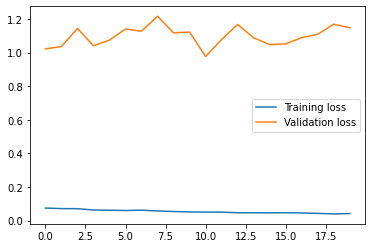

In [ ]:
plot_losses(losses)

In [ ]:
testing(loaders, model, criterion, gpu_available)

f1 for class NIL 0.7239263803680982
f1 for class MOD 0.572972972972973
f1 for class SEV 0.1142857142857143
Accuracy of   NIL : 63 %
Accuracy of   MOD : 65 %
Accuracy of   SEV : 40 %

Test Loss: 0.975808


Overall Test Accuracy: 63% (173/273)


## Train using LDAM with right hyperparameter $C$ and weight decay

In [ ]:
reset_model(model)
optimizerl2 = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
CCC=0.00001

print('C value is: '+str(CCC))

C value is: 1e-05


In [ ]:
#firstLDAM traning
losses = {'train':[], 'validation':[]}
model, losses = runEpochs(20, loaders, model, optimizerl2, 
                  gpu_available, 'model.pt', 'LDAM', DRW=False, sumloss=True)
model.load_state_dict(torch.load('model.pt'))
#saves the model
save_name = 'task2-l2.tar'
torch.save(model, save_name)
print(f'The best model saved to {save_name}')

Using LDAM Loss
Epoch: 1 	Training Loss: 20.212740 	Validation Loss: 8.189075
Validation loss decreased (inf --> 8.189075).  Saving model ...
Epoch: 2 	Training Loss: 15.729646 	Validation Loss: 7.312290
Validation loss decreased (8.189075 --> 7.312290).  Saving model ...
Epoch: 3 	Training Loss: 11.858776 	Validation Loss: 13.180241
Epoch: 4 	Training Loss: 10.087151 	Validation Loss: 6.928360
Validation loss decreased (7.312290 --> 6.928360).  Saving model ...
Epoch: 5 	Training Loss: 7.642620 	Validation Loss: 11.625158
Epoch: 6 	Training Loss: 7.187217 	Validation Loss: 8.285992
Epoch: 7 	Training Loss: 5.033768 	Validation Loss: 7.627141
Epoch: 8 	Training Loss: 5.188814 	Validation Loss: 14.623362
Epoch: 9 	Training Loss: 4.512947 	Validation Loss: 8.742574
Epoch: 10 	Training Loss: 3.917707 	Validation Loss: 6.486287
Validation loss decreased (6.928360 --> 6.486287).  Saving model ...
Epoch: 11 	Training Loss: 3.749815 	Validation Loss: 13.476285
Epoch: 12 	Training Loss: 3.5800

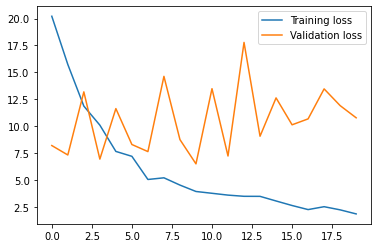

In [ ]:
plot_losses(losses)

In [ ]:
 testing(loaders, model, criterion, gpu_available)

f1 for class NIL 0.8288770053475935
f1 for class MOD 0.6530612244897959
f1 for class SEV 0.08000000000000002
Accuracy of   NIL : 82 %
Accuracy of   MOD : 59 %
Accuracy of   SEV : 20 %

Test Loss: 0.730679


Overall Test Accuracy: 74% (204/273)


## Train using LDAM with right hyperparameter $C$ on augmented data

In [ ]:
reset_model(model)
print('C value is: '+str(CCC))
#firstLDAM traning
losses = {'train':[], 'validation':[]}
model, losses = runEpochs(8, [loaders, trans_loader], model, optimizer, 
                  gpu_available, 'model.pt', 'LDAM', DRW=False, augment=True)
model.load_state_dict(torch.load('model.pt'))
#saves the model
save_name = 'task2-augmented.tar'
torch.save(model, save_name)
print(f'The best model saved to {save_name}')

C value is: 1e-05
Using LDAM Loss
Epoch: 1 	Training Loss: 1.071265 	Validation Loss: 0.944864
Validation loss decreased (inf --> 0.944864).  Saving model ...
Epoch: 2 	Training Loss: 1.046186 	Validation Loss: 0.903375
Validation loss decreased (0.944864 --> 0.903375).  Saving model ...
Epoch: 3 	Training Loss: 1.081740 	Validation Loss: 0.936575
Epoch: 4 	Training Loss: 1.083407 	Validation Loss: 0.997575
Epoch: 5 	Training Loss: 1.070711 	Validation Loss: 1.020228
Epoch: 6 	Training Loss: 1.077833 	Validation Loss: 1.032635
Epoch: 7 	Training Loss: 1.080778 	Validation Loss: 0.951521
Epoch: 8 	Training Loss: 1.080501 	Validation Loss: 0.904499
The best model saved to task2-augmented.tar


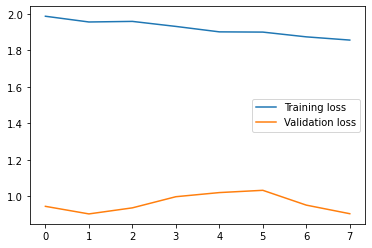

In [ ]:
plot_losses(losses)

In [ ]:
 testing(loaders, model, criterion, gpu_available)

f1 for class NIL 0.7014492753623188
f1 for class MOD 0.4324324324324325
f1 for class SEV 0.12500000000000003
Accuracy of   NIL : 64 %
Accuracy of   MOD : 49 %
Accuracy of   SEV : 20 %

Test Loss: 0.912651


Overall Test Accuracy: 59% (162/273)


#TASK 3
For task 3 our main update to our LDAM model was applying the Deferred Rebalancing Optimization(DRW) as explained in the main reference. What DW does is that after using the original LDAM we used in task 2 we train once more with doing a standard rewweighting based on the frequency of the clases and further more we normalize the the learning rate

## Best Result: Train using LDAM-DRW with right hyperparameter $C$ and weight decay

> Indented block



In [ ]:
reset_model(model)
print('C value is: '+str(CCC))
#firstLDAM traning
losses = {'train':[], 'validation':[]}
model, losses = runEpochs(20, loaders, model, optimizerl2, 
                  gpu_available, 'model.pt', 'LDAM', sumloss=True, DRW=False)
model.load_state_dict(torch.load('model.pt'))

losses = {'train':[], 'validation':[]}
model, losses = runEpochs(14, loaders, model, optimizerl2, 
                    gpu_available, 'model.pt', 'LDAM', sumloss=True, DRW=True, decay=0.01)
model.load_state_dict(torch.load('model.pt'))

C value is: 1e-05
Using LDAM Loss
Epoch: 1 	Training Loss: 53.491657 	Validation Loss: 9.200316
Validation loss decreased (inf --> 9.200316).  Saving model ...
Epoch: 2 	Training Loss: 53.320526 	Validation Loss: 8.909436
Validation loss decreased (9.200316 --> 8.909436).  Saving model ...
Epoch: 3 	Training Loss: 52.752018 	Validation Loss: 8.924428
Epoch: 4 	Training Loss: 51.048599 	Validation Loss: 8.311757
Validation loss decreased (8.909436 --> 8.311757).  Saving model ...
Epoch: 5 	Training Loss: 50.258377 	Validation Loss: 8.925216
Epoch: 6 	Training Loss: 48.536114 	Validation Loss: 9.169298
Epoch: 7 	Training Loss: 46.676338 	Validation Loss: 9.507012
Epoch: 8 	Training Loss: 42.569153 	Validation Loss: 8.808495
Epoch: 9 	Training Loss: 37.889919 	Validation Loss: 9.318415
Epoch: 10 	Training Loss: 32.497490 	Validation Loss: 9.984535
Epoch: 11 	Training Loss: 24.958256 	Validation Loss: 7.846390
Validation loss decreased (8.311757 --> 7.846390).  Saving model ...
Epoch: 12 	

<All keys matched successfully>

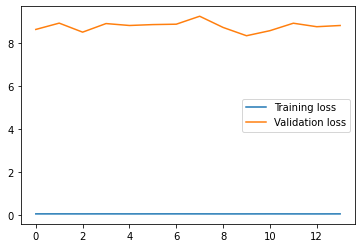

In [ ]:
#only second losses are printed
plot_losses(losses)

In [ ]:
 testing(loaders, model, criterion, gpu_available)

f1 for class NIL 0.609271523178808
f1 for class MOD 0.5167464114832536
f1 for class SEV 0.1142857142857143
Accuracy of   NIL : 49 %
Accuracy of   MOD : 66 %
Accuracy of   SEV : 40 %

Test Loss: 0.940309


Overall Test Accuracy: 54% (148/273)


# Conclusions
We now understandd how difficult it is to work with imbalanced datsets. A larger dataset for both training and validation would have greatly incresed 
In task 1 we used cross entropy and there we noticed our model getting often ovefitted. This motivated techniques to help with this in the future as adding dropout to the convolutional layer.  The weight decay proved to be better when using the parameter of decay=0.01. 

For the data augmentation we struggled on how to concatenate the new data into a data loader, `torch.utils.dta.ConatData()` changed the inputs to `np.array` for some reason so we ended up training on both of them separately. We did not liked the results of we obtained so we decided to not use them for the final model in task 3.

For Task 2, we had to define the LDAM loss into a class as we learned from googling that it is often done with making new loss functions. We specifically needed this to pass the parameters of the class we validate. The parameter tuning was a bit arduous since the value that gave the best results was very small. 

For task 3 we initially implemented DRW but the results we obtained were not what we expected so we sticked to the Task 2 result. Because of this we sticked with Task 2 using weight decay as our preferred model and sticked it as task3.tar